To run the following code, `pip install pandas, numpy, seaborn, duckdb, matplotlib, and cassandra-sigv4`. The expected outputs are as follow

In [ ]:
!pip install duckdb==1.2.2
import duckdb

### Part I

In [209]:
csv_folder = r"C:\Users\siddh\OneDrive - Northwestern University\Desktop\DATA ENG 300\HW2\mimic-iii-clinical-database-demo-1.4\mimic-iii-clinical-database-demo-1.4"

conn = duckdb.connect("mimiciii.db")
files = [
    "ADMISSIONS.csv",
    "ICUSTAYS.csv",
    "PATIENTS.csv",
    "PROCEDURES_ICD.csv",
    "D_ICD_PROCEDURES.csv",
    "DRGCODES.csv",
    "PRESCRIPTIONS.csv"
]

for file in files:
    table_name = file.replace(".csv", "").lower()
    file_path = f"{csv_folder}\\{file}"  
    conn.execute(f"""
        CREATE OR REPLACE TABLE {table_name} AS
        SELECT * FROM read_csv_auto('{file_path}')
    """)

#### Question 1

In [210]:
conn.sql(
    """
    SELECT DISTINCT ethnicity
    FROM admissions
    ORDER BY ethnicity;
    """
)


┌──────────────────────────────────────────────────────────┐
│                        ethnicity                         │
│                         varchar                          │
├──────────────────────────────────────────────────────────┤
│ AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE │
│ ASIAN                                                    │
│ BLACK/AFRICAN AMERICAN                                   │
│ HISPANIC OR LATINO                                       │
│ HISPANIC/LATINO - PUERTO RICAN                           │
│ OTHER                                                    │
│ UNABLE TO OBTAIN                                         │
│ UNKNOWN/NOT SPECIFIED                                    │
│ WHITE                                                    │
└──────────────────────────────────────────────────────────┘

In [211]:
conn.sql(
    """
    CREATE OR REPLACE TABLE admissions_cleaned AS
    SELECT *,
        CASE
            WHEN LOWER(ethnicity) IN (
                'unknown', 
                'unknown/not specified', 
                'unable to obtain', 
                'other', 
                'other/unknown'
            ) THEN 'Other/Unknown'
            ELSE ethnicity
        END AS ethnicity_cleaned
    FROM admissions;
    """
)


In [ ]:
conn.sql(
    """
    CREATE OR REPLACE TABLE prescriptions_cleaned AS
    SELECT 
        pr.hadm_id,
        pr.drug,
        TRY_CAST(pr.dose_val_rx AS DOUBLE) AS dose,
        ac.ethnicity_cleaned AS ethnicity
    FROM prescriptions pr
    JOIN admissions_cleaned ac
        ON pr.hadm_id = ac.hadm_id
    WHERE pr.dose_val_rx IS NOT NULL;
    """
)

In [ ]:
conn.sql(
    """
    CREATE OR REPLACE TABLE drug_totals_by_ethnicity AS
    SELECT
        ethnicity,
        drug,
        SUM(dose) AS total_amount
    FROM prescriptions_cleaned
    GROUP BY ethnicity, drug;
    """
)

In [214]:
amount_by_ethnicity_df = conn.sql(
    """
    SELECT *
    FROM (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY ethnicity ORDER BY total_amount DESC) AS rn
        FROM drug_totals_by_ethnicity
    )
    WHERE rn = 1
    ORDER BY ethnicity;
    """
).df()
amount_by_ethnicity_df.head()

,ethnicity,drug,total_amount,rn
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,16900.0,1
1,ASIAN,Heparin,15000.0,1
2,BLACK/AFRICAN AMERICAN,Heparin Sodium,150000.0,1
3,HISPANIC OR LATINO,5% Dextrose,19950.0,1
4,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,43663.0,1


 (b) I have written a series of smaller queries to answer question 1. To find the total drugs and their amount used by ethnicity, the query first groups together the `"UNKNOWN", "UNKNOWN/NOT SPECIFIED", "UNABLE TO OBTAIN"`,and `"OTHER/UNKNOWN"` categories into one category called `"Other/Unknown"` to get rid of redundant data. The query then, joins prescriptions and admissions using `hadm_id` to map each drug to the patient's ethnicity. Then, assuming that `dose_val_rx` is the amount of a drug used, the next query sums up this value while grouping by ethnicity and drug for each group to calculate the total amount of each drug used by ethnicity. Finally, `ROW_NUMBER()` is used to get the top usage in each ethnicity group based on the previously calculated total dose value.

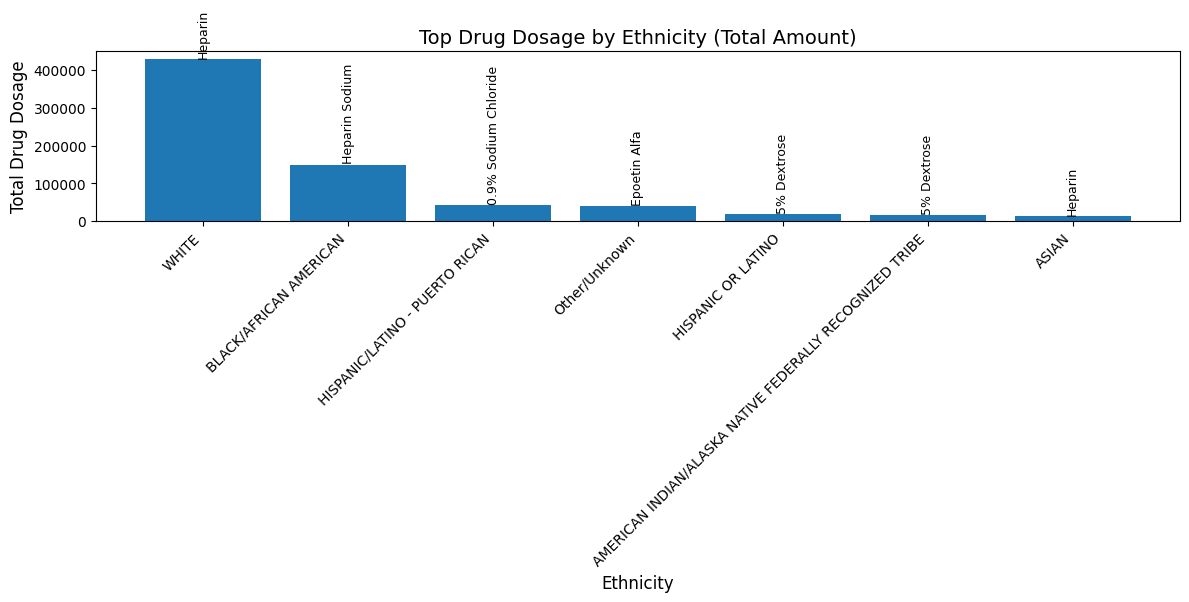

In [215]:
import matplotlib.pyplot as plt
import pandas as pd

amount_by_ethnicity_df["total_amount"] = pd.to_numeric(amount_by_ethnicity_df["total_amount"], errors='coerce')
amount_by_ethnicity_df = amount_by_ethnicity_df.sort_values(by='total_amount', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(amount_by_ethnicity_df["ethnicity"], amount_by_ethnicity_df["total_amount"])

for bar, drug in zip(bars, amount_by_ethnicity_df["drug"]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2000, drug, ha='center', va='bottom', fontsize=9, rotation=90)


plt.title("Top Drug Dosage by Ethnicity (Total Amount)", fontsize=14)
plt.xlabel("Ethnicity", fontsize=12)
plt.ylabel("Total Drug Dosage", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


(d) As can be seen in the bar graph above, Heparin is the most used drug among White people with a value of 427700 which is by far the highest number of doses in all the ethnicity groups. The next highest number of drug doses is 150000 for Heparin Sodium for people of Black or African American ethnicity. Puerto Rican Hispanic/Latino people use 0.9% Sodium Chloride the most. Hispanic/Latino people use 5% dextrose the most while Asians use Heparin the most. This suggests that Heparin and its variants seem to be the most commonly used drugs across ethnicities.

#### Question 2

In [216]:
conn.sql(
    """
    CREATE OR REPLACE TABLE patient_age AS
    SELECT 
        p.subject_id,
        a.hadm_id,
        DATE_PART('year', AGE(a.admittime, p.dob)) AS age
    FROM patients p
    JOIN admissions a ON p.subject_id = a.subject_id;
    """
)

In [ ]:
conn.sql(
    """
    CREATE OR REPLACE TABLE patient_age_grouped AS
    SELECT *,
        CASE 
            WHEN age <= 19 THEN '<=19'
            WHEN age BETWEEN 20 AND 49 THEN '20-49'
            WHEN age BETWEEN 50 AND 79 THEN '50-79'
            ELSE '>80'
        END AS age_group
    FROM patient_age;
    """
)

In [ ]:
conn.sql(
    """
    CREATE OR REPLACE TABLE procedures_by_age AS
    SELECT 
        pag.age_group,
        pr.icd9_code
    FROM patient_age_grouped pag
    JOIN procedures_icd pr 
        ON pag.subject_id = pr.subject_id AND pag.hadm_id = pr.hadm_id;
    """
)

In [ ]:
conn.sql(
    """
    CREATE OR REPLACE TABLE procedure_counts AS
    SELECT 
        age_group,
        icd9_code,
        COUNT(*) AS proc_count
    FROM procedures_by_age
    GROUP BY age_group, icd9_code;
    """
)

In [ ]:
conn.sql(
    """
    CREATE OR REPLACE TABLE procedures_with_names AS
    SELECT 
        pc.age_group,
        pc.icd9_code,
        dp.long_title AS procedure_name,
        pc.proc_count
    FROM procedure_counts pc
    LEFT JOIN d_icd_procedures dp ON pc.icd9_code = dp.icd9_code;
    """
)

In [251]:
top_3_df = conn.sql(
    """
    SELECT *
    FROM (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY proc_count DESC) AS rn
        FROM procedures_with_names
    )
    WHERE rn <= 3
    ORDER BY 
        CASE 
            WHEN age_group = '<=19' THEN 1
            WHEN age_group = '20-49' THEN 2
            WHEN age_group = '50-79' THEN 3
            WHEN age_group = '>80' THEN 4
            ELSE 5
        END,
        rn;
    """
).df()

top_3_df


,age_group,icd9_code,procedure_name,proc_count,rn
0,<=19,3893,"Venous catheterization, not elsewhere classified",3,1
1,<=19,8659,Closure of skin and subcutaneous tissue of oth...,2,2
2,<=19,0118,Other diagnostic procedures on brain and cereb...,1,3
3,20-49,3893,"Venous catheterization, not elsewhere classified",8,1
4,20-49,966,Enteral infusion of concentrated nutritional s...,7,2
5,20-49,5491,Percutaneous abdominal drainage,6,3
6,50-79,3893,"Venous catheterization, not elsewhere classified",26,1
7,50-79,966,Enteral infusion of concentrated nutritional s...,22,2
8,50-79,9904,Transfusion of packed cells,13,3
9,>80,3893,"Venous catheterization, not elsewhere classified",19,1


(b) This series of queries first calculates the age of the patient at the time of admission by calculating the difference between the admission time and the date of birth. It then groups the patients into the required four categories by age. These two tables are joined on the `hadm_id` and `subject_id` to connect the procedure to the patient for each distinct hospital visit. The count of each procedure is calculated by age group. The next part displays the long title for the procedure instead of the procedure code to make it more readable. Finally, a row number is assigned to each procedure within age groups based on `proc_count` to find the top three procedures by grouping the rows by `age_group`.

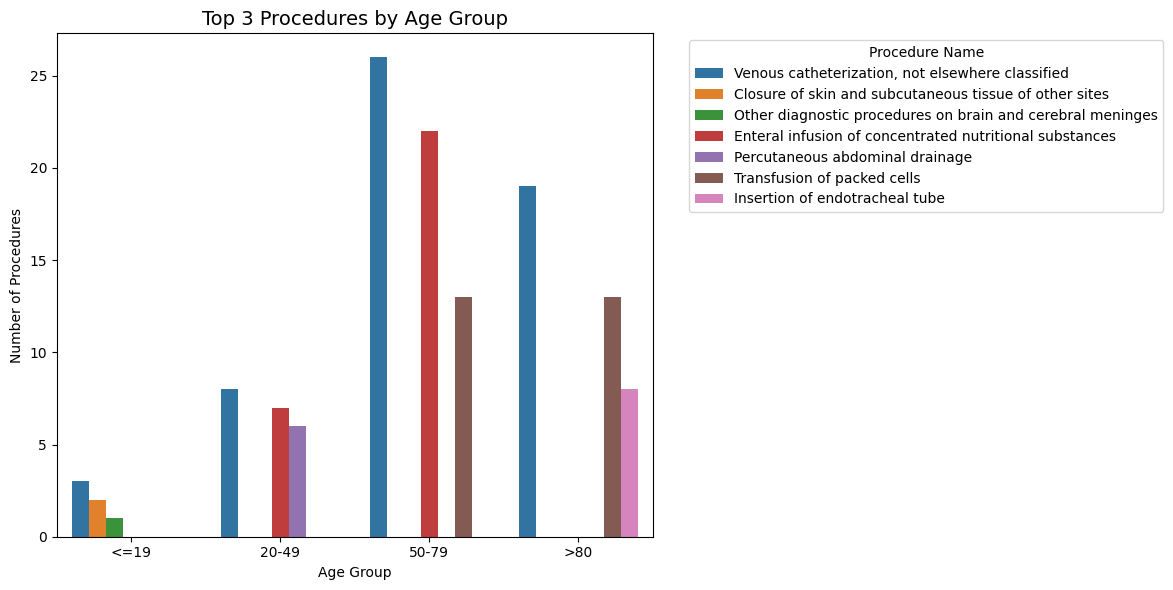

In [252]:
import matplotlib.pyplot as plt
import pandas as pdplt
import seaborn as sns

age_order = ['<=19', '20-49', '50-79', '>80']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_3_df,
    x='age_group',
    y='proc_count',
    hue='procedure_name',
    order=age_order
)

plt.title('Top 3 Procedures by Age Group', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Number of Procedures')
plt.legend(title='Procedure Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


(d) From the graph above, we can see that Venous catheterization is the most commonly performed procedure across all the age groups. For older age groups, above the age of 50, Transfusion of packed cells and Enteral infusion of concentrated nutritional substances appear consistently in the top three procedures. The number of procedures as well as the complexity of procedures performed increases significantly with age and is the highest in the 50-79 age group. This could also be due to the fact that there are lesser patients in the >80 category. For the age group below 19, the other two procedures with very low counts are Closure of skin and subcutaneous tissue of other and Repair of vertebral fracture indicating that there are very few patients below the age of 19 who underwent procedures and the ones who did had likely gotten into accidents. 

#### Question 3

In [ ]:
conn.sql("""
CREATE OR REPLACE TABLE icu_stays_duration AS
SELECT
    ie.subject_id,
    ROUND(DATE_DIFF('hour', ie.intime, ie.outtime), 2) AS icu_hours
FROM icustays ie
WHERE intime IS NOT NULL AND outtime IS NOT NULL;
""")

In [ ]:
conn.sql("""
CREATE OR REPLACE TABLE icu_stays_with_demo AS
SELECT 
    ie.subject_id,
    ie.hadm_id,
    ROUND(DATE_DIFF('hour', ie.intime, ie.outtime), 2) AS icu_hours,
    p.gender,
    LOWER(TRIM(a.ethnicity)) AS ethnicity
FROM icustays ie
JOIN patients p ON ie.subject_id = p.subject_id
JOIN admissions a ON ie.hadm_id = a.hadm_id
WHERE ie.intime IS NOT NULL AND ie.outtime IS NOT NULL;
""")

In [ ]:
conn.sql("""
CREATE OR REPLACE TABLE icu_cleaned_ethnicity AS
SELECT
    *,
    CASE
        WHEN ethnicity LIKE '%white%' THEN 'White'
        WHEN ethnicity LIKE '%black%' THEN 'Black'
        WHEN ethnicity LIKE '%hispanic%' THEN 'Hispanic'
        WHEN ethnicity LIKE '%asian%' THEN 'Asian'
        ELSE 'Other/Unknown'
    END AS ethnicity_group
FROM icu_stays_with_demo;
""")

In [226]:
conn.sql("""
SELECT
    gender,
    COUNT(*) AS num_stays,
    ROUND(AVG(icu_hours), 2) AS avg_hours,
    ROUND(MEDIAN(icu_hours), 2) AS median_hours
FROM icu_cleaned_ethnicity
GROUP BY gender;
""")

┌─────────┬───────────┬───────────┬──────────────┐
│ gender  │ num_stays │ avg_hours │ median_hours │
│ varchar │   int64   │  double   │    double    │
├─────────┼───────────┼───────────┼──────────────┤
│ F       │        63 │    132.98 │         58.0 │
│ M       │        73 │     84.32 │         46.0 │
└─────────┴───────────┴───────────┴──────────────┘

In [227]:
conn.sql("""
SELECT
    ethnicity_group,
    COUNT(*) AS num_stays,
    ROUND(AVG(icu_hours), 2) AS avg_hours,
    ROUND(MEDIAN(icu_hours), 2) AS median_hours
FROM icu_cleaned_ethnicity
GROUP BY ethnicity_group;
""")

┌─────────────────┬───────────┬───────────┬──────────────┐
│ ethnicity_group │ num_stays │ avg_hours │ median_hours │
│     varchar     │   int64   │  double   │    double    │
├─────────────────┼───────────┼───────────┼──────────────┤
│ Other/Unknown   │        17 │    131.24 │         64.0 │
│ Asian           │         2 │      93.0 │         93.0 │
│ Black           │         7 │    184.29 │         95.0 │
│ White           │        92 │     99.11 │         47.5 │
│ Hispanic        │        18 │     94.89 │         63.5 │
└─────────────────┴───────────┴───────────┴──────────────┘

(b) This query first calculates the duration of the ICU stay for each patient, in hours. It uses the `DATE_DIFF` function to subtract the intime from the outtime to calculate the number of hours a patient stays in the ICU. To analyze if there is a difference in gender and ethnicity, the duration table is joined with `patients` and `admissions` tables and cleaned by removing leading and trailing white spaces. Finally, the data is grouped by gender and ethnicity and the average ICU stay for each gender and each ethnicity is calculated. I calculated both the average and the median because the median is a better indicator if outliers are present. If some patients have really long stays, the mean can get skewed.

(d) We can see from the table above that females have a higher average ICU stay duration compared to males. Females spend around 132.98 hours on average with the median being 58 hours, while males spend around 84.32 hours on average with the median being 46 hours. The average and the median is higher for females.
As for the ethnicity, White patients had the highest number of ICU stays by far but had the lowest average ICU stay duration of 99 hours. Black patients had the highest average ICU stay duration of 184 hours with a suprisingly high median of 95 hours, but had fewer ICU stays compared to White patients and other ethnicities. Asians had the least number of ICU stays with an average length of 93 hours. The Hispanic patients had a similar average length of 94 hours but a median of 63.5 hours. A significant number of ICU stays were ambiguous ethnicity patients but they had an average ICU stay length of 132 hours with a median of 64 hours.  

### Part II

In [228]:
%pip install cassandra-sigv4


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [229]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1468  100  1468    0     0   6760      0 --:--:-- --:--:-- --:--:--  6796


In [ ]:
from cassandra.cluster import Cluster
from cassandra import ConsistencyLevel
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT

from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

C:\Users\siddh\AppData\Local\Temp\ipykernel_9536\2585281160.py:10: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [231]:
auth_provider = SigV4AuthProvider(boto_session)

In [ ]:
#cluster setup 
ep = ExecutionProfile(consistency_level=ConsistencyLevel.LOCAL_QUORUM)

cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider,
                  execution_profiles={EXEC_PROFILE_DEFAULT: ep}, 
                  port=9142)  # TLS only communicates on port 9142

In [ ]:
session = cluster.connect()

In [ ]:
session.execute("SELECT keyspace_name FROM system_schema.keyspaces;")
session.set_keyspace('mimic')

In [236]:
## creating the table

session.execute("""
    CREATE TABLE IF NOT EXISTS drug_amount_by_ethnicity (
        ethnicity_group TEXT,
        drug TEXT,
        total_amount DOUBLE,
        PRIMARY KEY (ethnicity_group, drug)
    );
""")

In [ ]:
## uploading the data

for _, row in amount_by_ethnicity_df.iterrows():
    session.execute("""
        INSERT INTO drug_amount_by_ethnicity (ethnicity_group, drug, total_amount)
        VALUES (%s, %s, %s)
    """, (row['ethnicity'], row['drug'], float(row['total_amount'])))

In [ ]:
rows = session.execute("SELECT * FROM drug_amount_by_ethnicity;")
df_keyspace = pd.DataFrame(rows)

(c) I did not use Cassandra for aggregation but used Pandas instead because I wanted to use functions such as limit and groupby that are only supported by pandas and found it simpler to use that.

In [253]:
## post extraction analysis using pandas

df_top_drug = (
    df_keyspace
    .sort_values(['ethnicity_group', 'total_amount'], ascending=[True, False])
    .groupby('ethnicity_group')
    .head(1)
)
df_top_drug

,ethnicity_group,drug,total_amount
5,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,16900.0
3,ASIAN,Heparin,15000.0
1,BLACK/AFRICAN AMERICAN,Heparin Sodium,150000.0
6,HISPANIC OR LATINO,5% Dextrose,19950.0
4,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,43663.0
0,Other/Unknown,Epoetin Alfa,40000.0
2,WHITE,Heparin,427700.0


(d) The data table printed above proves that the extraction produces the expected results.

In [240]:
## creating the table

session.execute("""
    CREATE TABLE IF NOT EXISTS procedures_by_age_group (
        age_group TEXT,
        icd9_code TEXT,
        procedure_name TEXT,
        proc_count INT,
        PRIMARY KEY (age_group, icd9_code)
    );
""")

In [ ]:
## uploading the data

for _, row in df_top_3.iterrows():
    session.execute("""
        INSERT INTO procedures_by_age_group (age_group, icd9_code, procedure_name, proc_count)
        VALUES (%s, %s, %s, %s)
    """, (
        row['age_group'],
        row['icd9_code'],
        row['procedure_name'],
        int(row['proc_count'])
    ))


In [ ]:
rows = session.execute("SELECT * FROM procedures_by_age_group;")
df_cassandra = pd.DataFrame(rows)

(c) For this question as well, pandas was used to sort and group the data and perform aggregation instead of cassandra because I wanted to use pandas specific functions.

In [ ]:
## post extraction analysis using pandas

df_top3 = (
    df_cassandra
    .sort_values(['age_group', 'proc_count'], ascending=[True, False])
    .groupby('age_group')
    .head(3)
)

In [244]:
print(df_top3)

   age_group icd9_code  proc_count  \
0      20-49      3893           8   
2      20-49       966           7   
1      20-49      5491           6   
10     50-79      3893          26   
11     50-79       966          22   
12     50-79      9904          13   
8       <=19      3893           3   
9       <=19      8659           2   
7       <=19      0118           1   
4        >80      3893          19   
6        >80      9904          13   
5        >80      9604           8   

                                       procedure_name  
0    Venous catheterization, not elsewhere classified  
2   Enteral infusion of concentrated nutritional s...  
1                     Percutaneous abdominal drainage  
10   Venous catheterization, not elsewhere classified  
11  Enteral infusion of concentrated nutritional s...  
12                        Transfusion of packed cells  
8    Venous catheterization, not elsewhere classified  
9   Closure of skin and subcutaneous tissue of oth...  
7

(d) As can be seen by the table above, the results are as expected and match the duckDB results.

In [245]:
## creating the table

session.execute("""
    CREATE TABLE IF NOT EXISTS icu_stay_summary_v2 (
        subject_id TEXT,
        hadm_id TEXT,
        icu_hours DOUBLE,
        gender TEXT,
        ethnicity_group TEXT,
        PRIMARY KEY ((subject_id), hadm_id)
    );
""")

In [ ]:
df_icu_summary = conn.sql("""
    SELECT 
        subject_id,
        hadm_id,
        icu_hours,
        gender,
        ethnicity_group
    FROM icu_cleaned_ethnicity;
""").df()

In [ ]:
## uplaoding the data

for _, row in df_icu_summary.iterrows():
    session.execute("""
        INSERT INTO icu_stay_summary_v2 (subject_id, hadm_id, icu_hours, gender, ethnicity_group)
        VALUES (%s, %s, %s, %s, %s)
    """, (
        str(row['subject_id']),
        str(row['hadm_id']),
        float(row['icu_hours']),
        row['gender'],
        row['ethnicity_group']
    ))

In [248]:
rows = session.execute("SELECT * FROM icu_stay_summary_v2;")
df_icu_keyspace = pd.DataFrame(rows)

In [ ]:
## post extraction analysis using pandas

gender_summary = (
    df_icu_keyspace
    .groupby('gender')['icu_hours']
    .agg(num_stays='count', avg_hours='mean', median_hours='median')
    .round(2)
    .reset_index()
)

ethnicity_summary = (
    df_icu_keyspace
    .groupby('ethnicity_group')['icu_hours']
    .agg(num_stays='count', avg_hours='mean', median_hours='median')
    .round(2)
    .reset_index()
)

(c) I used pandas for the post extraction analysis because I found it easier to group and summarize data using the pandas mean and median functions - that isn't possible directly in cassandra.

In [255]:
print(gender_summary)
print(ethnicity_summary)

  gender  num_stays  avg_hours  median_hours
0      F         59     137.07          58.0
1      M         70      86.80          46.5
  ethnicity_group  num_stays  avg_hours  median_hours
0           Asian          2      93.00          93.0
1           Black          7     184.29          95.0
2        Hispanic         17      95.12          62.0
3   Other/Unknown         17     131.24          64.0
4           White         86     102.78          48.0


(d) The results for this question are for the most part as expected. However, we see that there is a slight difference in the average hours spent. These minor discrepancies could be due to rounding differences, precision for floating point numbers, and missing rows during uploading to Cassandra. Since these are very minor differences, I think they will not affect the overall interpretation of the results.